In [ ]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Read and process dataset

In [ ]:
file = '/content/gdrive/MyDrive/dataset/Reviews.sqlite'

In [ ]:
con = sqlite3.connect(file)

In [ ]:
df = pd.read_sql_query(""" SELECT ProductId, UserId, Score FROM Reviews""", con) 
df.size

1705362

In [ ]:
df.head(3)

,ProductId,UserId,Score
0,B001E4KFG0,A3SGXH7AUHU8GW,5
1,B00813GRG4,A1D87F6ZCVE5NK,1
2,B000LQOCH0,ABXLMWJIXXAIN,4


In [ ]:
# Turn productId, userId into unqiue cat codes
df['ProductIdIdx'] = df['ProductId'].astype('category').cat.codes
df['UserIdIdx'] = df['UserId'].astype('category').cat.codes
# print(len(df['ProductIdIdx'].unique()))
# data = df[['ProductIdIdx', 'UserIdIdx', 'Score']]
df.head(3)

,ProductId,UserId,Score,ProductIdIdx,UserIdIdx
0,B001E4KFG0,A3SGXH7AUHU8GW,5,27619,188646
1,B00813GRG4,A1D87F6ZCVE5NK,1,72383,25105
2,B000LQOCH0,ABXLMWJIXXAIN,4,15267,210482


In [ ]:
n_users, n_products = len(df.UserIdIdx.unique()), len(df.ProductIdIdx.unique())
f'The dataset includes {len(df)} ratings by {n_users} unique users for {n_products} unique products'

'The dataset includes 568454 ratings by 256059 unique users for 74258 unique products'

### DNN Model

In [ ]:
# DNN_HIDDEN_UNITS = [64, 32, 16]
LEARNING_RATE = 0.0001

In [ ]:
dim_embedding_user = 40
dim_embedding_product = 40

#product embedding
product_input = Input(shape=[1],name = 'Product')
# product_input = preprocessing.scale(product_input)
product_embedding = Embedding(n_products+1,dim_embedding_product,name='Product-Embedding')(product_input)
product_vec = Flatten(name='product_flatten')(product_embedding)
product_vec = Dropout(0.2)(product_vec)

#user embedding
user_input = Input(shape=[1],name='User')
# user_input = preprocessing.scale(user_input)
user_embedding = Embedding(n_users+1,dim_embedding_user,name = 'User-Embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding)
user_vec = Dropout(0.2)(user_vec)

#concatenate flattened values
concat = concatenate([product_vec,user_vec])
concat_dropout = Dropout(0.2)(concat)

#dense layer
dense1 = Dense(256,name='Fully-Connected1',activation='relu')(concat)
dense2 = Dense(64,activation='relu')(dense1)
result = Dense(1,activation='relu',name='Activation')(dense2)
#define model
model = Model([user_input,product_input],result)
#show model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Product (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Product-Embedding (Embedding)  (None, 1, 40)        2970360     ['Product[0][0]']                
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 40)        10242400    ['User[0][0]']                   
                                                                                              

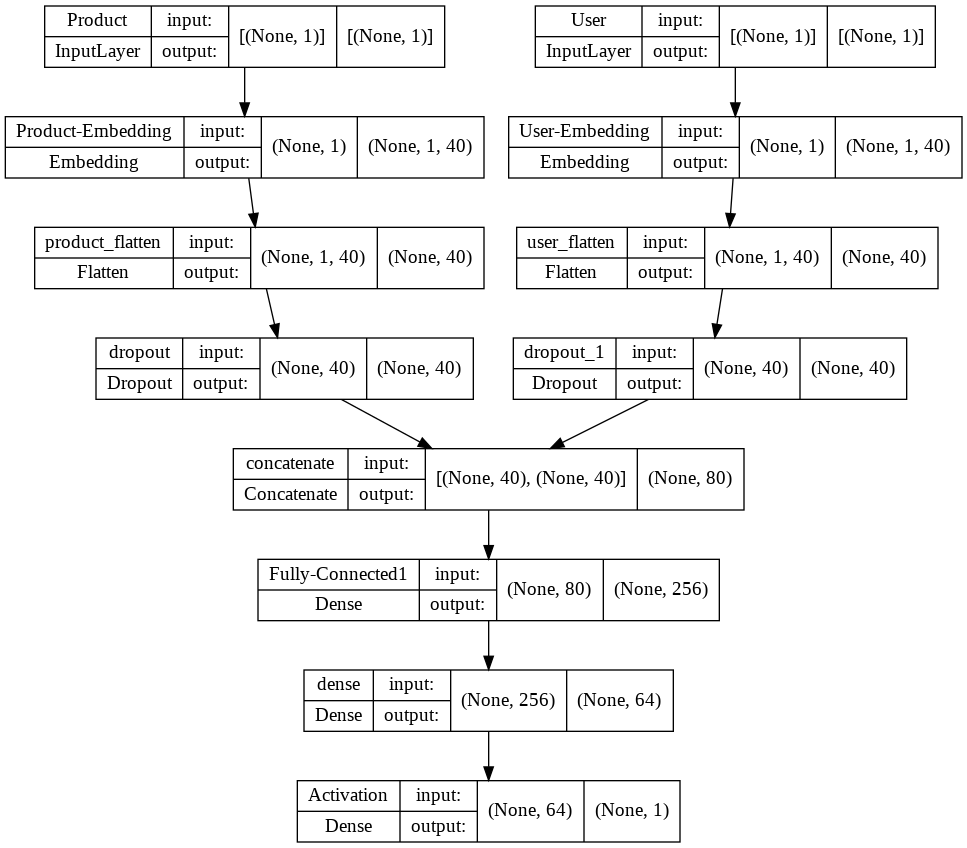

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Train the Model

In [ ]:
opt_adam = Adam(lr = LEARNING_RATE)
## compile model
model.compile(
    optimizer= opt_adam, 
    # loss= ['mse'], 
    loss = tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), 'mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 1)

In [ ]:
def epoch_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = 0.8
    lrate = initial_lrate * math.pow(drop, epoch)
    # epochs_drop = 1.0
    # lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop)
    # )
    return lrate

lrate = LearningRateScheduler(epoch_decay)

In [ ]:
## fit model
history = model.fit([df['UserIdIdx'],df['ProductIdIdx']],
                    df['Score'],
                    batch_size = 128,
                    validation_split = 0.1,
                    epochs = 5,
                    callbacks = [earlystop, lrate],
                    verbose = 1)

Epoch 1/5
3997/3997 [==============================] - 583s 146ms/step - loss: 1.9061 - rmse: 1.3806 - mae: 1.0629 - val_loss: 1.4964 - val_rmse: 1.2233 - val_mae: 0.9839 - lr: 1.0000e-04
Epoch 2/5
3997/3997 [==============================] - 566s 142ms/step - loss: 1.1168 - rmse: 1.0568 - mae: 0.7618 - val_loss: 1.4140 - val_rmse: 1.1891 - val_mae: 0.9154 - lr: 8.0000e-05
Epoch 3/5
3997/3997 [==============================] - 563s 141ms/step - loss: 0.8207 - rmse: 0.9059 - mae: 0.6015 - val_loss: 1.4679 - val_rmse: 1.2116 - val_mae: 0.8975 - lr: 6.4000e-05


In [ ]:
pd.DataFrame(history.history)

,loss,rmse,mae,val_loss,val_rmse,val_mae,lr
0,1.906086,1.380611,1.062860,1.496410,1.223279,0.983899,0.000100
1,1.116777,1.056777,0.761782,1.414043,1.189135,0.915384,0.000080
2,0.820664,0.905905,0.601468,1.467877,1.211560,0.897509,0.000064


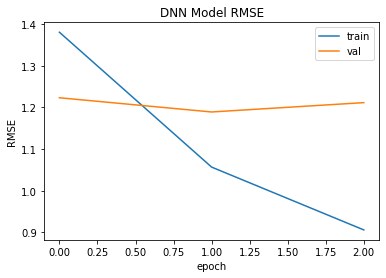

In [ ]:
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('DNN Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
# plt.savefig(data_dir + 'result.png')
plt.show()

Reference: 

Movie Recommendation System with Neural Networks and Collaborative Filtering (Explicit Feedback)
https://medium.com/@bhawna7374/movie-recommendation-system-with-neural-networks-and-collaborative-filtering-explicit-feedback-d2afaafef350